In [19]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics import JaccardIndex
import matplotlib.pyplot as plt
import seaborn as sns

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Checkpoint, ExperimentAnalysis
import tempfile

from dataset.uavid_dataset import UAVidDataset
from models.unet import UNet
from losses.focal_loss import PixelwiseFocalLoss
from utils.visualizations import visualize_inference, plot_best_trial_metrics

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.cuda.empty_cache()

In [4]:
START_TRAINING = False

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
mapping = {
    (0, 0, 0): 0,
    (128, 128, 0): 1,
    (128, 64, 128): 2,
    (128, 0, 0): 3,
    (64, 64, 0): 4,
    (64, 0, 128): 5,
    (0, 128, 0): 6,
    (192, 0, 192): 7
}

reversed_mapping = {v: k for k, v in mapping.items()}

data_path = os.path.abspath('/teamspace/studios/this_studio/uavid-semantic-segmentation/uavid_dataset/')

In [7]:
def load_data(root_dir, train_transforms, valid_transforms, mapping, config):
    train_dataset = UAVidDataset(root_dir=root_dir, data_part='train', class_mapping=mapping, transforms=train_transforms)
    valid_dataset = UAVidDataset(root_dir=root_dir, data_part='valid', class_mapping=mapping, transforms=valid_transforms)

    train_loader = DataLoader(
        train_dataset, 
        batch_size=int(config["batch_size"]), 
        shuffle=True, 
        num_workers=4,
        pin_memory=True, 
        persistent_workers=True
    )
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=int(config["batch_size"]), 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True, 
        persistent_workers=True
    )

    return train_loader, valid_loader

In [8]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.25),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.25),
    A.GaussianBlur(blur_limit=(3, 5), p=0.25),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.Resize(540, 960),
    ToTensorV2(transpose_mask=True)
])

valid_transforms = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.Resize(540, 960),
    ToTensorV2(transpose_mask=True)
])

train_loader, valid_loader = load_data('uavid_dataset/', train_transforms=train_transforms, valid_transforms=valid_transforms, mapping=mapping, config={'batch_size': 32})

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [9]:
images, masks = next(iter(train_loader))

In [10]:
unique, counts = torch.unique(masks.flatten(), return_counts=True)
total = counts.sum()
weights = counts.float() / total

for class_id, count, weight in zip(unique, counts, weights):
    print(f"class {class_id}: {count} pixels ({weight:.4f})")

class 0: 3226630 pixels (0.1945)
class 1: 1985432 pixels (0.1197)
class 2: 1838898 pixels (0.1109)
class 3: 4964000 pixels (0.2992)
class 4: 26845 pixels (0.0016)
class 5: 194622 pixels (0.0117)
class 6: 4162980 pixels (0.2510)
class 7: 189393 pixels (0.0114)


In [11]:
def train_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, device: torch.device, jaccard: JaccardIndex, accumulation_steps: int):
    model.train()
    total_loss = 0
    total_iou = 0
    
    optimizer.zero_grad()

    for i, (data, target) in enumerate(train_loader):
        data = data.float().to(device, non_blocking=True)
        target = target.long().to(device, non_blocking=True)
               
        output = model(data)
        loss = criterion(output, target) / accumulation_steps
        
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
 
        total_loss += loss.item() * accumulation_steps
        
        with torch.no_grad():
            pred = output.argmax(dim=1)
            iou = jaccard(pred, target)
            total_iou += iou.item()
        
        del data, target, output, pred, loss
        
    if (i + 1) % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    return total_loss / len(train_loader), total_iou / len(train_loader)


def valid_epoch(model: nn.Module, valid_loader: DataLoader, criterion: nn.Module, device: torch.device, jaccard: JaccardIndex):
    model.eval()
    total_loss = 0
    total_iou = 0

    with torch.no_grad():
        for data, target in valid_loader:
            data = data.float().to(device, non_blocking=True)
            target = target.long().to(device, non_blocking=True)

            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()

            pred = output.argmax(dim=1)
            iou = jaccard(pred, target)
            total_iou += iou.item()
            
            del data, target, output, pred, loss

    return total_loss / len(valid_loader), total_iou / len(valid_loader)

def evaluate(model: nn.Module, loader: DataLoader, device: torch.device, is_test: bool = False):
    model.eval()
    predictions = []
    targets = []
    image_paths = []

    with torch.no_grad():
        for batch in loader:
            if is_test:
                data, paths = batch
                data = data.float().to(device, non_blocking=True)
                output = model(data)
                pred = output.argmax(dim=1)

                predictions.append(pred.cpu())
            else:
                data, target = batch
                data = data.float().to(device, non_blocking=True)
                target = target.long().to(device, non_blocking=True)
                
                output = model(data)
                pred = output.argmax(dim=1)
                
                predictions.append(pred.cpu())
                targets.append(target.cpu())
            
            del data, output, pred

    predictions = torch.cat(predictions, dim=0)
    
    if is_test:
        return predictions, image_paths
    else:
        targets = torch.cat(targets, dim=0)
        return predictions, targets

In [12]:
def train_unet(config, data_dir=None):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
    
    train_loader, valid_loader = load_data(
        data_dir, 
        train_transforms=train_transforms, 
        valid_transforms=valid_transforms, 
        mapping=mapping, 
        config=config
    )

    model = UNet(8, config.get('dropout_prob', 0.2))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = PixelwiseFocalLoss(alpha=weights.to(device) if weights is not None else None)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    epochs = config.get('epochs', 20)

    jaccard = JaccardIndex(task='multiclass', num_classes=8).to(device)

    for epoch in range(epochs):
        try:
            train_loss, train_iou = train_epoch(
                model, train_loader, criterion, optimizer, device, 
                jaccard, accumulation_steps=config.get('accumulation_steps', 4)
            )
            val_loss, val_iou = valid_epoch(model, valid_loader, criterion, device, jaccard)
            
            scheduler.step(val_loss)
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                checkpoint_path = os.path.join(temp_checkpoint_dir, "checkpoint.pth")
                torch.save(model.state_dict(), checkpoint_path)
                
                tune.report(
                    {"loss": val_loss, "iou": val_iou, "train_loss": train_loss, "train_iou": train_iou},
                    checkpoint=Checkpoint.from_directory(temp_checkpoint_dir)
                )
        except torch.cuda.OutOfMemoryError as e:
            print(f"OOM Error in epoch {epoch}: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            raise e
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [13]:
if START_TRAINING:
    unet_config = {
        "lr": tune.loguniform(1e-4, 1e-1),
        "weight_decay": tune.loguniform(1e-6, 1e-2),
        "batch_size": tune.choice([2, 4]),
        "dropout_prob": tune.loguniform(0.1, 0.25),
        "accumulation_steps": tune.choice([4, 8]),
        "epochs": 20
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=20,
        grace_period=2,
        reduction_factor=2
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_unet, data_dir=data_path),
            resources={"cpu": 4, "gpu": 0.5} 
        ),
        param_space=unet_config,
        tune_config=tune.TuneConfig(
            scheduler=scheduler,
            num_samples=10
        )
    )

    unet_results = tuner.fit()

    best_result_unet = unet_results.get_best_result(metric="loss", mode="min")
    print(f"\nBest trial config: {best_result_unet.config}")
    print(f"Best trial final validation IoU: {best_result_unet.metrics['iou']:.4f}")
    print(f"Best trial final validation loss: {best_result_unet.metrics['loss']:.4f}")

In [14]:
checkpoint_dir = None

try:
    best_result_unet = unet_results.get_best_result(metric="loss", mode="min")
    best_checkpoint = best_result_unet.checkpoint
    with best_checkpoint.as_directory() as checkpoint_dir_path:
        checkpoint_path = os.path.join(checkpoint_dir_path, "checkpoint.pth")
        checkpoint_dir = "/".join(checkpoint_dir_path.split("/")[:-1])
except NameError:
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_')]
    if checkpoint_files:
        latest_checkpoint = sorted(checkpoint_files)[-1]
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint, "checkpoint.pth")
    else:
        checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_unet = UNet(8)
model_unet.load_state_dict(torch.load(checkpoint_path, map_location=device))
model_unet.to(device)
model_unet.eval()

UNet(
  (down1): Downsample(
    (down): DoubleConvolution(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (dropout): Dropout2d(p=0.0, inplace=False)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Downsample(
    (down): DoubleConvolution(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pa

In [15]:
dataset = UAVidDataset(root_dir=data_path, data_part='valid', class_mapping=mapping, transforms=valid_transforms)

loader = DataLoader(
    dataset, 
    batch_size=16, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True, 
    persistent_workers=True
)

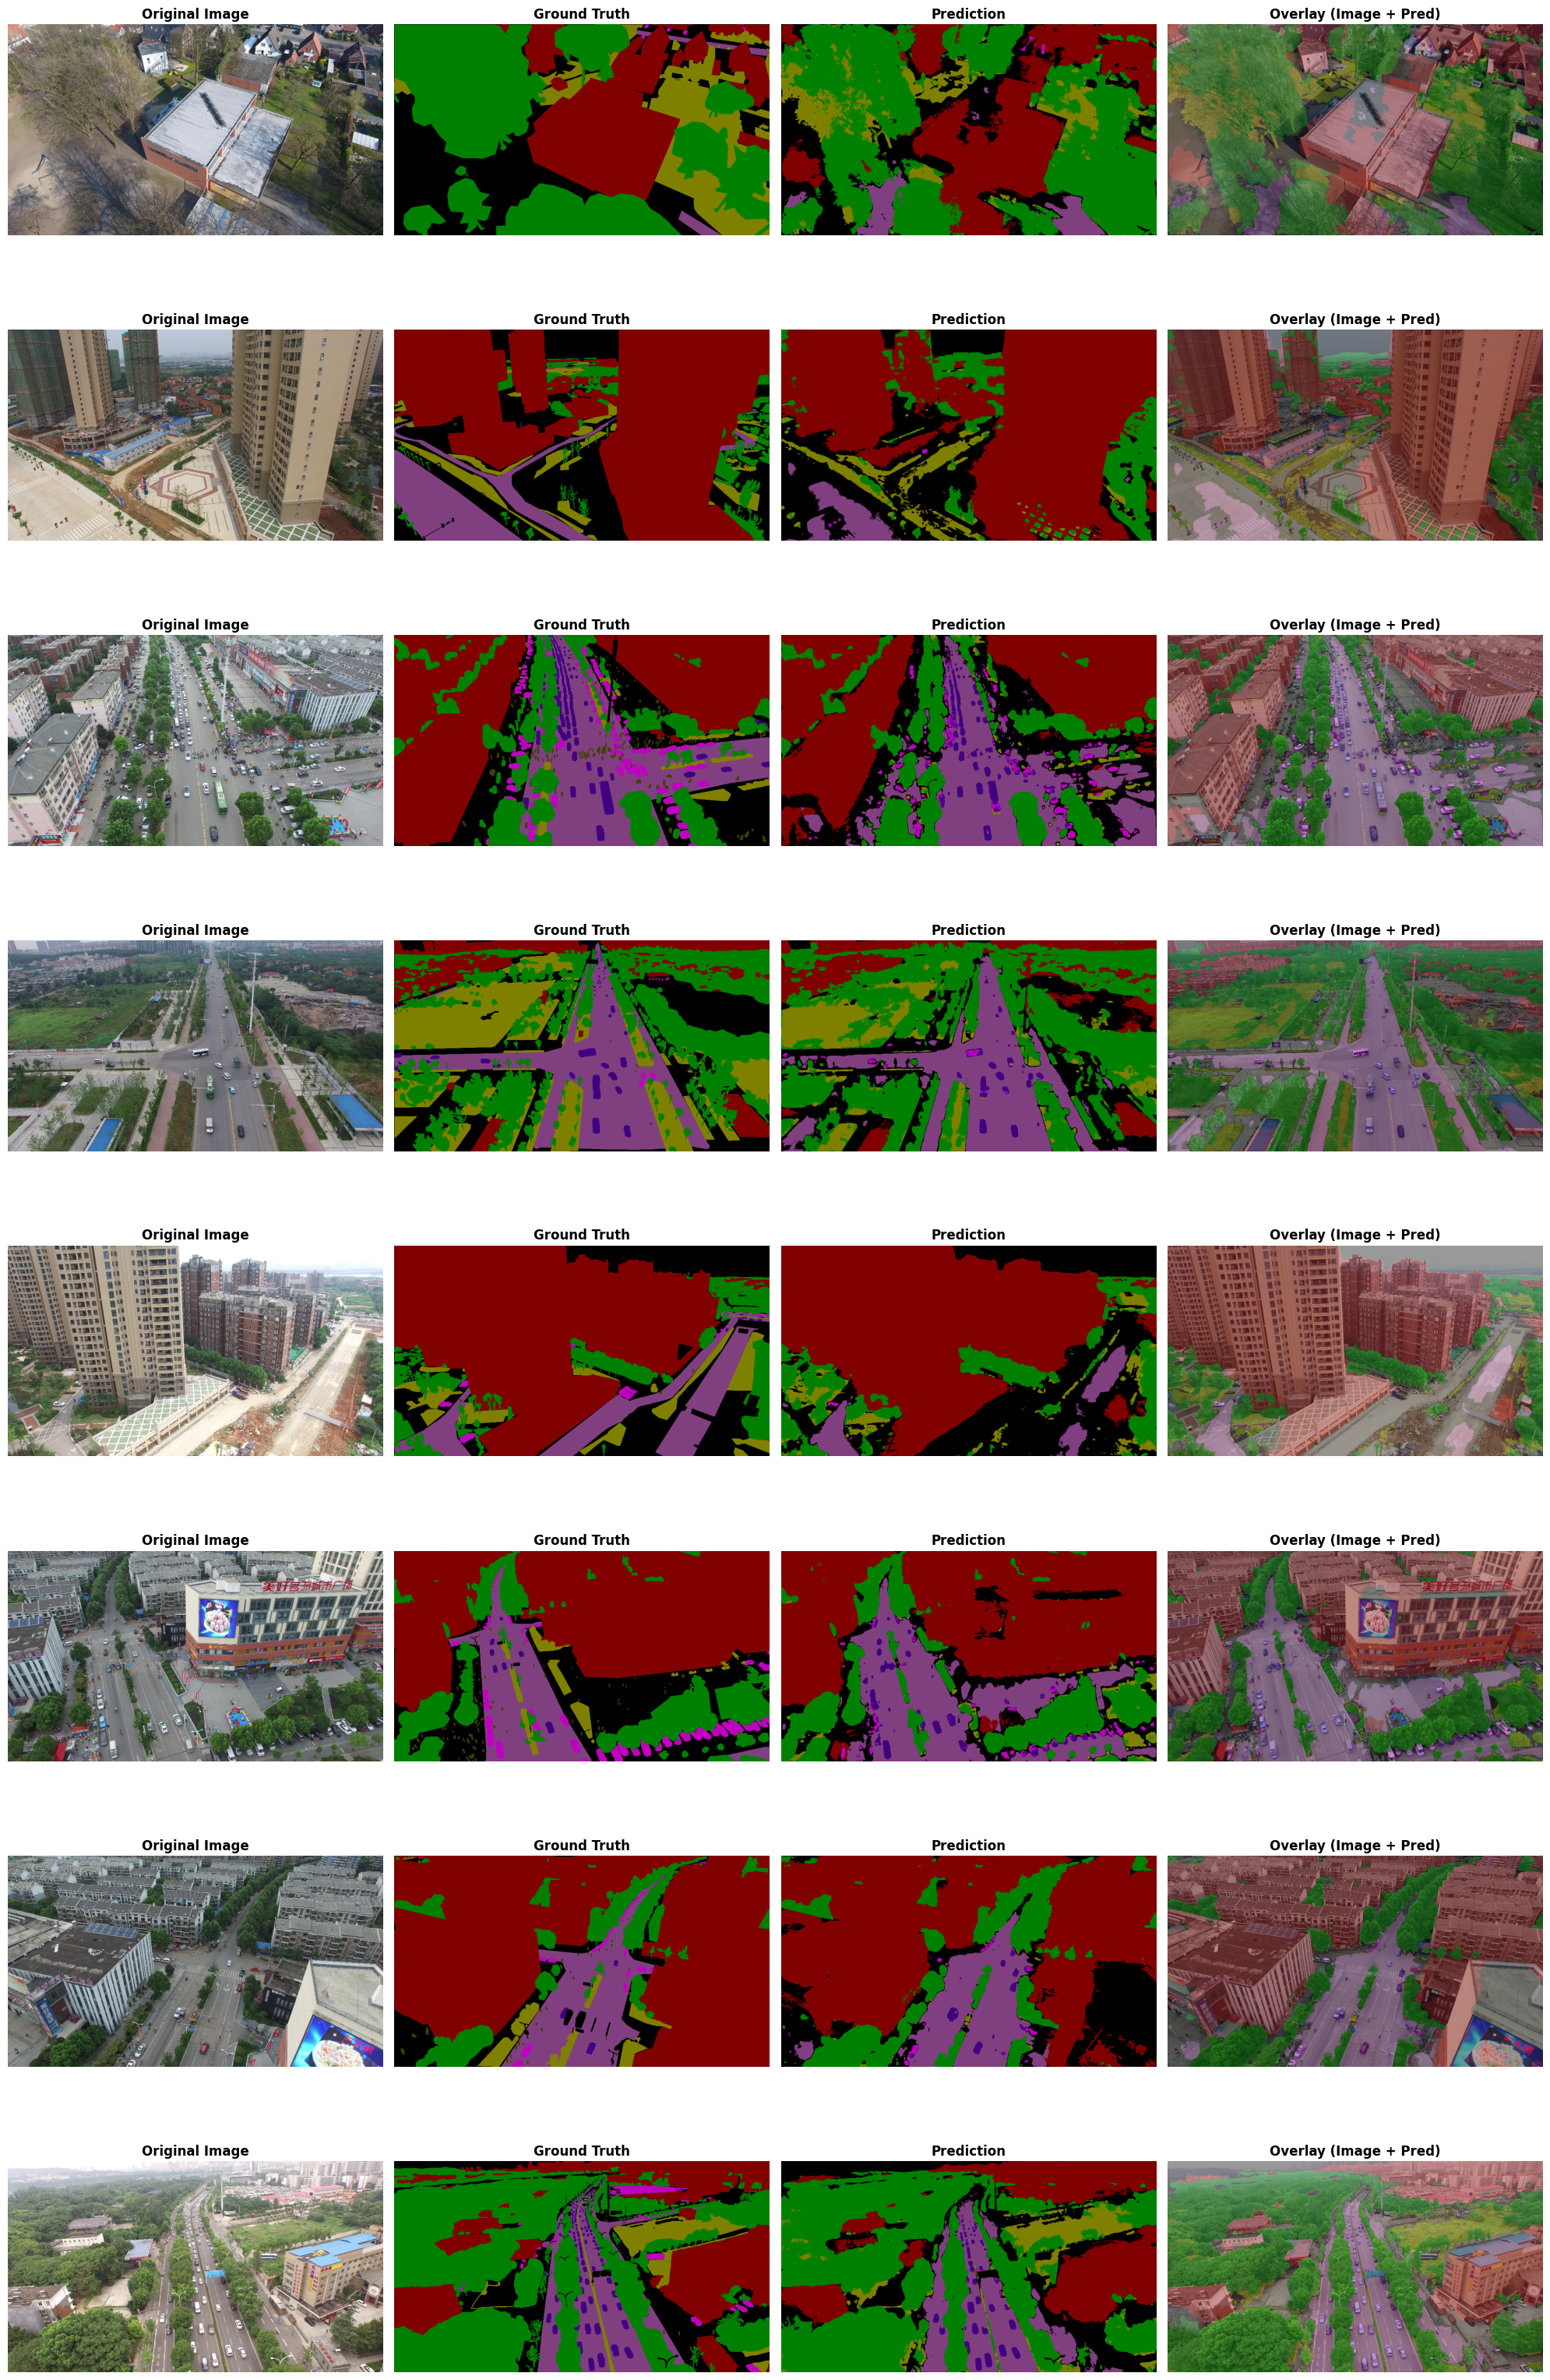

In [16]:
visualize_inference(
    model=model_unet,
    dataloader=loader,
    device=device,
    reversed_mapping=reversed_mapping,
    num_samples=8
)

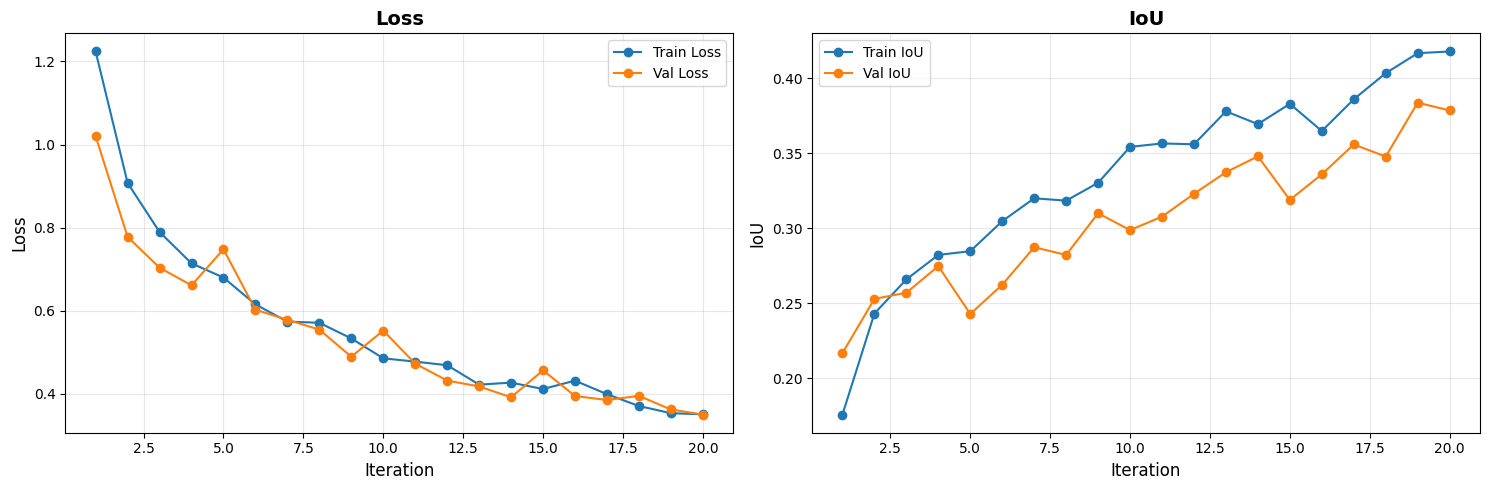

In [17]:
plot_best_trial_metrics(
    f"{checkpoint_dir}/progress.csv"
)

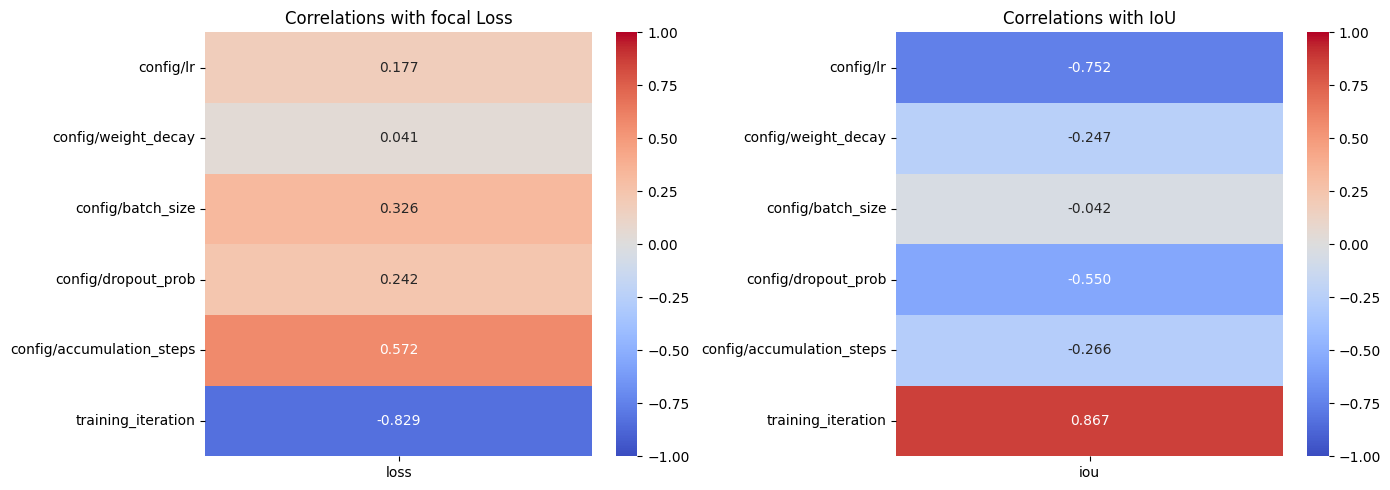

In [21]:
analysis = ExperimentAnalysis("/".join(checkpoint_dir.split("/")[:-1]))

results_df = analysis.dataframe()

param_cols = ['config/lr', 'config/weight_decay', 'config/batch_size', 
              'config/dropout_prob', 'config/accumulation_steps', 'training_iteration']

results_clean = results_df[param_cols + ['loss', 'iou']].dropna()

results_clean['config/batch_size'] = results_clean['config/batch_size'].astype(float)
results_clean['config/accumulation_steps'] = results_clean['config/accumulation_steps'].astype(float)

corr_matrix = results_clean.corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(corr_matrix[['loss']].iloc[:-2], annot=True, fmt='.3f', cmap='coolwarm', ax=axes[0], vmin=-1, vmax=1, center=0)
axes[0].set_title('Correlations with focal Loss')

sns.heatmap(corr_matrix[['iou']].iloc[:-2], annot=True, fmt='.3f', cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1, center=0)
axes[1].set_title('Correlations with IoU')

plt.tight_layout()
plt.show()

Based on the correlation matrices, learning rate shows the strongest correlation with IoU (-0.752), followed by dropout probability (-0.550) for model performance. For loss, accumulation steps (0.572) and batch size (0.326) demonstrate the highest correlations. However, these correlations are not reliable indicators of true parameter importance because Ray Tune with ASHAScheduler employs early stopping - it terminates poorly performing trials before completion. This means trials with certain parameter combinations never reach full training, creating a biased sample where we're comparing completed trials against prematurely stopped ones.

### Conclusions

We chose focal loss because it is used to solve problems of small and unbalanced classes, where instances of small classes suffer more in the loss calculation process. In addition to the loss value, we also looked at the Jaccard index (also known as the IoU score) to see how well the model correctly predicted each pixel. 

Based on this, we can see that the model has difficulty finding the difference between a moving car and a stationary car, and the same situation is observed between low vegetation and trees. The model occasionally detects tree clusters in photos that are mislabeled. We can see that even with relatively small IoU (0.378) it have good ability to generalize. Perhaps some classical morphological methods can be applied to remove noise and improve overall modal performance.